### Build and test a Naive Bayes classifier.

We will again use the iris data. 

Goals for this notebook:
1. Understand NB well enough to make a prediction by hand
2. Use the naive_bayes module in scikit-learn
3. First glimpse at the pandas package for manipulating data

In [129]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import train_test_split

In [130]:
# Load the data, which is included in sklearn.
iris = load_iris()
print 'Iris target names:', iris.target_names
print 'Iris feature names:', iris.feature_names
X, y = iris.data, iris.target

Iris target names: ['setosa' 'versicolor' 'virginica']
Iris feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [131]:
# Train/test split
print X.shape
X_train, X_test, y_train, y_test = train_test_split(X, y)

(150, 4)


In [132]:
print X_train.shape
print X_test.shape
print y_train.shape

(112, 4)
(38, 4)
(112,)


## EDA

The iris feature values are real valued measurements in centimeters. Let's look at histograms of each feature.

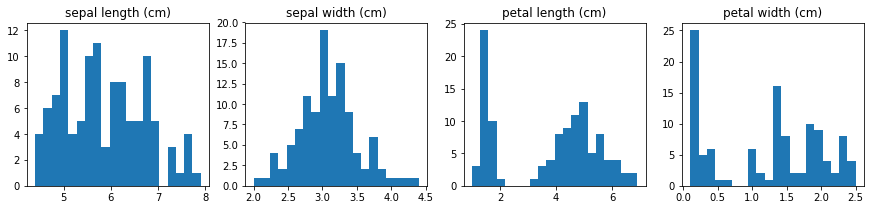

In [133]:
# Create a new figure and set the figsize argument so we get square-ish plots of the 4 features.
plt.figure(figsize=(15, 3))

# Iterate over the features, creating a subplot with a histogram for each one.
for feature in range(X_train.shape[1]):
    plt.subplot(1, 4, feature+1)
    plt.hist(X_train[:,feature], 20)
    plt.title(iris.feature_names[feature])

In [134]:
X_train[:5,:]

array([[ 6.9,  3.1,  5.4,  2.1],
       [ 6.7,  3.1,  4.7,  1.5],
       [ 4.8,  3. ,  1.4,  0.3],
       [ 5.8,  4. ,  1.2,  0.2],
       [ 6.1,  3. ,  4.9,  1.8]])

In [135]:
# Define a function that applies a threshold to turn real valued iris features into 0/1 features.
# 0 will mean "short" and 1 will mean "long".
def binarize_iris(data, thresholds=[6.0, 3.0, 2.5, 1.0]):
    # Initialize a new feature array with the same shape as the original data.
    binarized_data = np.zeros(data.shape)

    # Apply a threshold  to each feature.
    for feature in range(data.shape[1]):
        binarized_data[:,feature] = data[:,feature] > thresholds[feature]
    return binarized_data

# Create new binarized training and test data
binarized_train_data = binarize_iris(X_train)
binarized_test_data = binarize_iris(X_test)

print X_train[:10, ]
print binarized_train_data[:10, ]

[[ 6.9  3.1  5.4  2.1]
 [ 6.7  3.1  4.7  1.5]
 [ 4.8  3.   1.4  0.3]
 [ 5.8  4.   1.2  0.2]
 [ 6.1  3.   4.9  1.8]
 [ 5.2  3.5  1.5  0.2]
 [ 6.4  3.2  5.3  2.3]
 [ 5.1  3.7  1.5  0.4]
 [ 6.2  3.4  5.4  2.3]
 [ 6.   2.9  4.5  1.5]]
[[ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [ 0.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 1.  0.  1.  1.]
 [ 0.  1.  0.  0.]
 [ 1.  1.  1.  1.]
 [ 0.  1.  0.  0.]
 [ 1.  1.  1.  1.]
 [ 0.  0.  1.  1.]]


Recall that Naive Bayes assumes conditional independence of features. With $Y$ the set of labels and $X$ the set of features ($y$ is a specific label and $x$ is a specific feature), Naive Bayes gives the probability of a label $y$ given input features $X$ as:

$ \displaystyle P(y|X) \approx 
  \frac { P(y) \prod_{x \in X} P(x|y) }
        { \sum_{y \in Y} P(y) \prod_{x \in X} P(x|y) }
$

Let's estimate some of these probabilities using maximum likelihood, which is just a matter of counting and normalizing. We'll start with the prior probability of the label $P(y)$.

In [136]:
# Initialize counters for all labels to zero.
label_counts = [0 for i in iris.target_names]

# Iterate over labels in the training data and update counts.
for label in y_train:
    label_counts[label] += 1

# Normalize counts to get a probability distribution.
total = sum(label_counts)
label_probs = [1.0 * count / total for count in label_counts]
for (prob, name) in zip(label_probs, iris.target_names):
    print '%15s : %.2f' %(name, prob)

         setosa : 0.34
     versicolor : 0.32
      virginica : 0.34


### Repeat above three cells using pandas

Pandas allows us to stop thinking about code in terms of procedures, and start thinking about code in terms of _data manipulation_.

- Check out pandas here: pandas.pydata.org
- [Here](https://github.com/pandas-dev/pandas/blob/master/doc/cheatsheet/Pandas_Cheat_Sheet.pdf) is cheat sheet to get a sense for what is possible.
- [This](http://pandas.pydata.org/pandas-docs/stable/10min.html) is probably the best place to get started


Load the training data into a pandas data frame

In [137]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [138]:
colnames = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
df = pd.DataFrame(X, columns=colnames)
df.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [139]:
# set target
target = pd.Series(y)
target.head()

0    0
1    0
2    0
3    0
4    0
dtype: int64

In [140]:
df['target'] = target
df.head()

,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [141]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], 
      dtype='|S10')

In [142]:
df = df.replace({'target':{0:'setosa', 1:'versicolor', 2:'virginica'}})

In [143]:
# Train test split
train_df, test_df = train_test_split(df)
train_df.head()

,sepal_length,sepal_width,petal_length,petal_width,target
58,6.6,2.9,4.6,1.3,versicolor
128,6.4,2.8,5.6,2.1,virginica
59,5.2,2.7,3.9,1.4,versicolor
64,5.6,2.9,3.6,1.3,versicolor
86,6.7,3.1,4.7,1.5,versicolor


Plot some histograms

Binarize the columns

In [144]:
# for training dataset
train_df.head()
thresholds = [6.0, 3.0, 2.5, 1.0]
train_df_binarized = train_df[colnames].apply(lambda row: row > thresholds, axis =1)
train_df_binarized.head()

,sepal_length,sepal_width,petal_length,petal_width
58,True,False,True,True
128,True,False,True,True
59,False,False,True,True
64,False,False,True,True
86,True,True,True,True


In [145]:
# again for test dataset
test_df.head()
thresholds = [6.0, 3.0, 2.5, 1.0]
test_df_binarized = test_df[colnames].apply(lambda row: row > thresholds, axis =1)
test_df_binarized.head()

,sepal_length,sepal_width,petal_length,petal_width
90,False,False,True,True
2,False,True,False,False
104,True,False,True,True
136,True,True,True,True
28,False,True,False,False


Estimate priors

In [146]:
train_df['target'].value_counts(normalize=True)

setosa        0.339286
virginica     0.330357
versicolor    0.330357
Name: target, dtype: float64

## Naive Bayes by Hand

Next, let's estimate $P(X|Y)$, that is, the probability of each feature given each label. Remember that we can get the conditional probability from the joint distribution:

$\displaystyle P(X|Y) = \frac{ P(X,Y) } { P(Y) } \approx \frac{ \textrm{Count}(X,Y) } { \textrm{Count}(Y) }$

Let's think carefully about the size of the count matrix we need to collect. There are 3 labels $y_1$, $y_2$, and $y_3$ and 4 features $x_0$, $x_1$, $x_2$, and $x_3$. Each feature has 2 possible values, 0 or 1. So there are actually $4 \times 2 \times 3=24$ probabilities we need to estimate: 

$P(x_0=0, Y=y_0)$

$P(x_0=1, Y=y_0)$

$P(x_1=0, Y=y_0)$

$P(x_1=1, Y=y_0)$

...

However, we already estimated (above) the probability of each label. And, we know that each feature value is either 0 or 1. So, for example,

$P(x_0=0, Y=\textrm{setosa}) + P(x_0=1, Y=\textrm{setosa}) = P(Y=\textrm{setosa}) \approx 0.31$.

As a result, we can just estimate probabilities for one of the feature values, say, $x_i = 1$. This requires a $4 \times 3$ matrix.

In [147]:
thresholds

[6.0, 3.0, 2.5, 1.0]

In [148]:
# Append the target to train_df_binarized
train_df_binarized['target'] = train_df['target']
train_df_binarized.head()

,sepal_length,sepal_width,petal_length,petal_width,target
58,True,False,True,True,versicolor
128,True,False,True,True,virginica
59,False,False,True,True,versicolor
64,False,False,True,True,versicolor
86,True,True,True,True,versicolor


In [149]:
subdf = train_df_binarized.loc[train_df_binarized['target']=='versicolor']
subdf.head()

,sepal_length,sepal_width,petal_length,petal_width,target
58,True,False,True,True,versicolor
59,False,False,True,True,versicolor
64,False,False,True,True,versicolor
86,True,True,True,True,versicolor
99,False,False,True,True,versicolor


In [150]:
print subdf['sepal_length'].value_counts()
print subdf['sepal_length'].value_counts(normalize=True)
print subdf['sepal_length'].mean()
# tells you that out of all the obsevations that at versicolor this value is greater than 6.0

False    22
True     15
Name: sepal_length, dtype: int64
False    0.594595
True     0.405405
Name: sepal_length, dtype: float64
0.405405405405


In [151]:
# Calculate all the conditional probabilities
conditional_probs = train_df_binarized.groupby('target').mean()
conditional_probs

,sepal_length,sepal_width,petal_length,petal_width
target,,,,
setosa,0.000000,0.815789,0.0,0.000000
versicolor,0.405405,0.189189,1.0,0.891892
virginica,0.810811,0.324324,1.0,1.000000


That is P(sepal length > 1 | versicolor) = .35

In [152]:
# Calculate Priors
priors = train_df['target'].value_counts(normalize=True)
priors

setosa        0.339286
virginica     0.330357
versicolor    0.330357
Name: target, dtype: float64

In [153]:
priors['setosa']

0.3392857142857143

Now that we have all the pieces, let's try making a prediction for the first test example. 

In [154]:
test_example = test_df.iloc[0]
test_example

sepal_length           5.5
sepal_width            2.6
petal_length           4.4
petal_width            1.2
target          versicolor
Name: 90, dtype: object

In [155]:
test_example_binzarized = test_df_binarized.iloc[0]
test_example_binzarized

sepal_length    False
sepal_width     False
petal_length     True
petal_width      True
Name: 90, dtype: bool

#### Exercise

Let's step through the process of computing what Naive Bayes has to say about this specific test example. That is, we want to compute:
- P('versicolor' | test_example_binarized)
- P('virginica' | test_example_binarized)
- P('setosa' | test_example_binarized)

All the information we need is below:

In [156]:
print priors
print
print conditional_probs
print
print test_example_binzarized

setosa        0.339286
virginica     0.330357
versicolor    0.330357
Name: target, dtype: float64

            sepal_length  sepal_width  petal_length  petal_width
target                                                          
setosa          0.000000     0.815789           0.0     0.000000
versicolor      0.405405     0.189189           1.0     0.891892
virginica       0.810811     0.324324           1.0     1.000000

sepal_length    False
sepal_width     False
petal_length     True
petal_width      True
Name: 90, dtype: bool


In [157]:
# The probability of sepal_width is above the threshold given versicolor is  0.294118 

In [158]:
test_example_binzarized

sepal_length    False
sepal_width     False
petal_length     True
petal_width      True
Name: 90, dtype: bool

1: Write a function that takes a label as input and returns _log of the numerator_ of the NB equation. That is, $
\log \left[ P(y) * P(x | y) \right]
$

In [159]:
def lognum(label):
    """
    For this function, we imagine a hard coded observation:
        
        test_example = [sepal_length=False, sepal_width=False, petal_length=True, petal_width=True]
        
    Input: (string) One of 'versicolor', 'viriginica', or 'setosa'
    Output: log P(test_example | label) (using the independence assumption)
    """    
    
    p_label = priors[label]
    p_sl = 1 - conditional_probs.loc[label, 'sepal_length'] # because FALSE - I know it is below thresh
    p_sw = 1 - conditional_probs.loc[label, 'sepal_width'] # Because FALSE
    p_pl = conditional_probs.loc[label, 'petal_length'] # TRUE
    p_pw = conditional_probs.loc[label, 'petal_width'] # TRUE
    return np.sum(np.log([p_label, p_sl, p_sw, p_pl, p_pw]))


In [160]:
conditional_probs


,sepal_length,sepal_width,petal_length,petal_width
target,,,,
setosa,0.000000,0.815789,0.0,0.000000
versicolor,0.405405,0.189189,1.0,0.891892
virginica,0.810811,0.324324,1.0,1.000000


Test

In [161]:
label = 'virginica'
lognum("virginica")

-3.1646308100158054

2: Compute the log of the numberator for each possible label

In [ ]:
lognum.apply(np.exp) / lognums()

3: Convert the results of (2) into probabilities

## Naive Bayes in Scikit-Learn

In [ ]:
print train_df_binarized.head()
print test_df_binarized.head()

### BernoulliNB means _the features are distributed Bernoulli_

How accurate is the BernoulliNB classifier, when trained on train_df_binarized, and tested on test_df_binarized?

In [ ]:
from sklearn.naive_bayes import BernoulliNB


### GaussianNB _means the features are distributed Gaussian_

Exercise: Build a GaussianNB model using sklearn, and estimate the accuracy on the test set.

In [ ]:
from sklearn.naive_bayes import GaussianNB


Let's look at those predicted probabilities

The predicted probabilities are _very_ confident. Since the test predictions are also extremely accurate, we might conclude that GaussianNB is an appropriate model

### MultinomialNB _means the features are distributed multinomial_

In [ ]:
cuts = [0, .2, .4, .6, .8, 1]
breaks = train_df[colnames].quantile(cuts)
breaks.loc[0, :] = 0  # Set a global minimimum
breaks.loc[1, :] = 10  # Set a global maximum
print breaks

In [ ]:
# Discretize each column according to the breaks defined above
train_df_mult = train_df[colnames].apply(
    lambda col: pd.cut(col, bins=breaks[col.name], include_lowest=True, labels=False)
)
test_df_mult = test_df[colnames].apply(
    lambda col: pd.cut(col, bins=breaks[col.name], include_lowest=True, labels=False))

In [ ]:
train_df_mult.head()

In [ ]:
from sklearn.naive_bayes import MultinomialNB



## Bonus:

Consider the following threshold possibilities for each of the four features.

```
sepal_length_thresh = [5.0, 5.6, 6.2, 6.5]
sepal_width_thresh = [2.7, 3.0, 3.2, 3.4]
petal_length_thresh = [2, 3, 4, 5]
petal_width_thresh = [.5, 1, 1.5, 2]
```

Find the combination of thresholds (one from each list), that gives the BernoulliNB model with the highest accuracy.

Use a train/test/dev split, and report accuracy on the test set.